
## Play with Himawari cloud mask data and xarray (distributed)


In [1]:
import os,sys
from glob import glob
#
import xarray as xr
import dask.array as da
from dask.distributed import Client
from dask.dot import dot_graph
# 
import numpy as np
import cartopy.crs as ccrs
import matplotlib
matplotlib.use('agg')
import matplotlib.pyplot as plt
from datetime import datetime


# timer
import time
class Timer:    
    def __enter__(self):
        self.start = time.clock()
        return self
    def __exit__(self, *args):
        self.end = time.clock()
        self.interval = self.end - self.start


/home1/datahome/aponte/.miniconda2/envs/daskdist/lib/python2.7/site-packages/distributed/utils.py:114: RuntimeWarning: Couldn't detect a suitable IP address for reaching '8.8.8.8', defaulting to '127.0.0.1': [Errno 101] Network is unreachable
  % (host, default, e), RuntimeWarning)


In [2]:
# 
nx, ny, nt = 2401, 2401, 22556 # requires 18 nodes
nx, ny, nt = 2401, 2401, 1000 # requires 1 node only
Sdata = nx*ny*nt*8/1e9
print 'Size of the full dataset is %.1f GB' %(Sdata)
number_of_nodes = 2
workers_per_node = 28
RAM_per_node = 60.  # GB (120 in fact on datarmor)
#(nx*ny)/(number_of_nodes*workers_per_node)

Nnodes = np.ceil(Sdata /RAM_per_node)
print 'Number of nodes (workers) required to fit everything in memory: %d (%d)' %(Nnodes,Nnodes*workers_per_node)
## nx*ny = chunksize*workers_per_node*Nnodes
#print 'Corresponding number chunksize (horizontal grid points number): %d' %(nx*ny/(workers_per_node*Nnodes))
## approx. same as estimate below


### if chunks are taken over space:

print '--- if chunks are taken over time'
## chunksize * nt *8/1e9 * workers_per_node = RAM_per_node
chunksize = RAM_per_node/(nt *8./1e9 * workers_per_node)
print 'Chunksize (horizontal grid points number) required to fit time line in memory = %d' %chunksize

chunksize=1000
## chunksize * nt * workers_per_node * Nnodes = nx * ny * nt 
#  chunksize*nt *8/1.e9    nx*ny
print 'Now if chunksize = %d, the number of nodes should be approx. %d' %(chunksize, nx*ny/chunksize/workers_per_node)


### if chunks are taken over time:

print '--- if chunks are taken over time'
RAM_per_worker = RAM_per_node/workers_per_node
# nx*ny*t *8/1e9 = RAM_per_worker
print 'One worker can hold %d time steps' %(RAM_per_worker/(nx*ny*8/1e9))
print 'RAM_per_worker = %0.1f GB' %(RAM_per_worker)


Size of the full dataset is 46.1 GB
Number of nodes (workers) required to fit everything in memory: 1 (28)
--- if chunks are taken over time
Chunksize (horizontal grid points number) required to fit time line in memory = 267857
Now if chunksize = 1000, the number of nodes should be approx. 205
--- if chunks are taken over time
One worker can hold 46 time steps
RAM_per_worker = 2.1 GB


In [3]:
### get dask handles and check dask server status
client = Client(scheduler_file=os.path.join(os.path.expanduser('~'), 'scheduler.json'))
client.restart()

Client Scheduler: tcp://10.148.0.32:8786 Dashboard: http://10.148.0.32:8787,Cluster Workers: 111 Cores: 111 Memory: 449.83 GB


In [4]:
# data path
dpath = '/home1/scratch/aponte/hw/mask/';

filenames = sorted(glob(dpath+'*.nc'))
print 'Number of files available: %d' %len(filenames)
Nfiles = len(filenames)
# tmp, subset number of files
#filenames = filenames[:24*2*30*3]
filenames = filenames[:1000] # 10000 fails, 5000 passes
print 'Number of files processed: %d' %len(filenames)

with Timer() as t:
    #ds = xr.open_mfdataset(filenames,concat_dim='time',chunks={'longitude':100,'latitude':100}, autoclose=True)
    mask = xr.open_mfdataset(filenames,concat_dim='time', compat='equals', autoclose=True, lock=False)['QA']
    #mask = mask.chunk(chunks={'longitude':150,'latitude':100})
    mask = mask.chunk(chunks={'time':20})
print('tttt   load_data took %.03f sec.' % t.interval)
    
# build time line from filenames and store ut ub tule coordinate
#fname_pref='NC_H08_'+YYYYMM+DD+'_'+hh+mm+'_L2CLPbet_FLDK.02401_02401.nc'
mask['time'] = [datetime.strptime(f,dpath+'NC_H08_%Y%m%d_%H%M_L2CLPbet_FLDK.02401_02401.nc') for f in filenames]

# subset further data if necessary
#mask = mask.isel(time=0,longitude=1000)
#mask = mask.isel(time=0)

print mask

Number of files available: 23377
Number of files processed: 1000
tttt   load_data took 19.795 sec.
<xarray.DataArray 'QA' (time: 1000, latitude: 2401, longitude: 2401)>
dask.array<rechunk-merge, shape=(1000, 2401, 2401), dtype=float64, chunksize=(40, 2401, 2401)>
Coordinates:
  * latitude   (latitude) float32 60.0 59.95 59.9 59.85 59.8 59.75 59.7 ...
  * longitude  (longitude) float32 80.0 80.05 80.1 80.15 80.2 80.25 80.3 ...
  * time       (time) datetime64[ns] 2016-03-01 2016-03-01T00:30:00 ...
Attributes:
    long_name:    Quality Assurance
    units:        Dimensionless
    valid_min:    0
    valid_max:    65535
    description:  (2,1,0) Cloud Retrieval Algorithm Flag: 000=Outside of Scan...


In [5]:
print 'Full dataset size: %f GB' %(Nfiles/len(filenames) * mask.nbytes/1e9)
print 'Dataset size: %f GB' %(mask.nbytes/1e9)

#%time mask.load()
# load leads to network crash

Full dataset size: 1060.723384 GB
Dataset size: 46.118408 GB


In [6]:
# massage the mask to get cloud flag
rint = xr.ufuncs.rint
fmod = xr.ufuncs.fmod

def process_mask(mask):
    #QA:description = "
    #(2,1,0) Cloud Retrieval Algorithm Flag: 000=Outside of Scan, 001=No Cloud Mask,
    #        010=Clear, 011=Failed, 100=Successful: Low Confidence, 101=Successful: High Confidence, 110=TBD, 111=TBD; 
    #(4,3) Cloud Mask Confidence Level Flag: 00=Clear, 01=Probably Clear, 10=Probably Cloudy, 11=Cloudy; 
    #(6,5) Cloud Retrieval Phase Flag: 00=Clear, 01=Liquid Water, 10=Mixed or Uncertain, 11=Ice; 
    #(7) Spare: 0=TBD, 1=TBD;
    #(8) Sunglint Flag: 0=Yes, 1=No; 
    #(9) Snow Ice Background Possibility Flag: 0=Yes, 1=No; 
    #(11,10) Land/Water Flag: 00=Water, 01=Coastal, 10=TBD, 11=Land; 
    #(12) SOZ>80 or SAZ>70: 0=Yes, 1=No; 
    #(13) Subpixel Inhomogeneity Flag: 0=Yes, 1=No; 
    #(14) Multilayer Cloud Flag: 0=Yes, 1=No; 
    #(15) Inversion Layer Flag: 0=Yes, 1=No;" ;
    #
    fmask=xr.ones_like(mask)
    ### (2,1,0) Cloud Retrieval Algorithm Flag
    code=[]
    for i in xrange(3):
        code.append(rint(fmod(mask,2)))
        mask=mask//2
    fmask = fmask.where( (code[0]==0) & (code[1]==1) & (code[2]==0))
    ### (4,3) Cloud Mask Confidence Level Flag: 00=Clear, 01=Probably Clear, 10=Probably Cloudy, 11=Cloudy;
    code=[]
    for i in xrange(2):
        code.append(rint(fmod(mask,2)))
        mask=mask//2
    #fmask = fmask.where( (code[0]==0) & (code[1]==0) )
    #fmask = fmask.where( code[1]==1 )
    ### skips next
    for i in xrange(5):
        mask=mask//2
    ### (11,10) Land/Water Flag: 00=Water, 01=Coastal, 10=TBD, 11=Land; 
    code=[]
    for i in xrange(2):
        code.append(rint(fmod(mask,2)))
    #    #code.append(np.rint(mask%2))
        mask=mask//2
    fmask = fmask.where( (code[0]==0) & (code[1]==0) )
    
    return fmask


with Timer() as t:
    fmask = process_mask(mask)
    fmask = fmask.fillna(0)
print('tttt   mask processing took %.03f sec.' % t.interval)
#print fmask

tttt   mask processing took 0.064 sec.


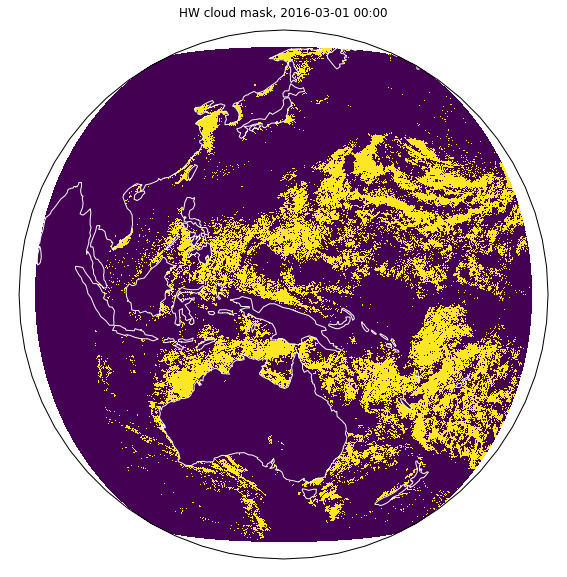

tttt   plot one snapshot took 11.536 sec.


In [7]:
# plot one snapshot

# note, can't download coastlines from cluster nodes:
# wget http://naciscdn.org/naturalearth/110m/physical/ne_110m_coastline.zip
# (unzip, rename)
# mv 110m_coastline.* ~/.local/share/cartopy/shapefiles/natural_earth/physical/

def plot_mask(mask, colorbar=False, title=None):
    plt.figure(figsize=(10,10))
    ax = plt.axes(projection=ccrs.Geostationary(central_longitude=140.0));    
    mask.plot.pcolormesh(ax=ax, transform=ccrs.PlateCarree(),
                         x='longitude', y='latitude', add_colorbar=colorbar);
    ax.coastlines(color='w')
    if title is None:
        date = str(fmask.isel(time=0)['time'].values).split(':00.')[0].replace('T',' ')
        ax.set_title('HW cloud mask, '+date)
    else:
        ax.set_title(title)
    #plt.show()

# plot
with Timer() as t:
    plot_mask(fmask.isel(time=0))
print('tttt   plot one snapshot took %.03f sec.' % t.interval)
plt.savefig('figs/hw_snapshot.png')


In [8]:
# plot a temporal average
with Timer() as t:
    plot_mask(fmask.mean('time'),title='Mean',colorbar=True)
print('tttt   compute and plot temporal average took %.03f sec.' % t.interval)
plt.savefig('figs/hw_mean.png')



distributed.utils - ERROR - ("('broadcast_to-0da9f6b1bf2c816192a37d9c74f5f0c3', 0, 0, 0)", 'tcp://10.148.0.32:43146')
Traceback (most recent call last):
  File "/home1/datahome/aponte/.miniconda2/envs/daskdist/lib/python2.7/site-packages/distributed/utils.py", line 223, in f
    result[0] = yield make_coro()
  File "/home1/datahome/aponte/.miniconda2/envs/daskdist/lib/python2.7/site-packages/tornado/gen.py", line 1055, in run
    value = future.result()
  File "/home1/datahome/aponte/.miniconda2/envs/daskdist/lib/python2.7/site-packages/tornado/concurrent.py", line 238, in result
    raise_exc_info(self._exc_info)
  File "/home1/datahome/aponte/.miniconda2/envs/daskdist/lib/python2.7/site-packages/tornado/gen.py", line 1063, in run
    yielded = self.gen.throw(*exc_info)
  File "/home1/datahome/aponte/.miniconda2/envs/daskdist/lib/python2.7/site-packages/distributed/client.py", line 1235, in _gather
    traceback)
  File "<string>", line 2, in reraise
KilledWorker: ("('broadcast_to-0da

KilledWorker: ("('broadcast_to-0da9f6b1bf2c816192a37d9c74f5f0c3', 0, 0, 0)", 'tcp://10.148.0.32:43146')